In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import re
import utils
import functools

%load_ext autoreload
%autoreload 2

In [29]:
def read_data(directory, regex=None, debug_regex=False):
    directory = Path(directory)
    # some variables reused below
    extra_columns = ['ImageNumber', 'Parent_Cell']
    
    extras = {
        'extra_columns': extra_columns,
        'merge_fcn': functools.partial(utils.merge_result, merge_on=extra_columns)
    }
    
    # Parse information from filename using the provided regex
    result, _ = utils.analyze(directory / 'Image.csv', 
                              parsers=[
                                  utils.ImageParser(regex, debug_regex=debug_regex),                              
                              ])
    # Combine with DilatedGC for using to merge with other measures
    result, _ = utils.analyze(directory / 'Cell.csv',
                              previous_result=result,
                              parsers=[
                                  utils.BlankParser(['ObjectNumber']),
                              ],
                              extra_columns=['ImageNumber', ],
                              merge_fcn=functools.partial(utils.merge_result, merge_on=['ImageNumber'], how='left'),
                             )
    result, _ = utils.analyze(directory / 'Cell.csv',
                              previous_result=result,
                              parsers=[
                                      utils.IntensityParser(images=['plasmid_star', 'endogenous_28S']),
                              ],
                              region='Cell',
                              extra_columns=['ImageNumber', 'ObjectNumber'],
                              merge_fcn=functools.partial(utils.merge_result, merge_on=['ImageNumber', 'ObjectNumber']),
                             )
    result = result.rename(columns={'ObjectNumber': 'Parent_Cell'})
    
    # Measure features from objects
    for region in ('Nuclei', 'Cytoplasm'):
        result, _ = utils.analyze(directory / f'{region}.csv',
                                  previous_result=result,
                                  parsers=[
                                      utils.IntensityParser(images=['plasmid_star', 'endogenous_28S']),
                                  ],
                                  region=region,
                                  **extras
                                 )
    return result

data = read_data('/scratch/gpfs/tcomi/cp_paper_redo/exogenous_cytoplasm/testing/outputs', 
                 r'/[A-G]\d+_(?P<treatment>[^_]+).*nd2$', 
                 )
# data.loc[data.isna().any(axis=1), 'Metadata_FileLocation'].unique()
data

,ImageNumber,Metadata_FileLocation,Metadata_Series,treatment,Parent_Cell,Cell_MeanIntensity_endogenous_28S,Cell_MeanIntensity_plasmid_star,Nuclei_MeanIntensity_endogenous_28S,Nuclei_MeanIntensity_plasmid_star,Cytoplasm_MeanIntensity_endogenous_28S,Cytoplasm_MeanIntensity_plasmid_star
0,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,1,0.012856,0.002883,0.005650,0.000504,0.016546,0.004101
1,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,2,0.006802,0.002642,0.004824,0.002474,0.010288,0.002938
2,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,3,0.008992,0.001765,0.005714,0.000851,0.014533,0.003288
3,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,4,0.009066,0.000749,0.005647,0.000469,0.013587,0.001105
4,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,7,0.008584,0.000443,0.005668,0.000340,0.016467,0.000721
5,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,8,0.008740,0.000259,0.005338,0.000221,0.013571,0.000313
6,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,9,0.009430,0.000271,0.005964,0.000234,0.015915,0.000340
7,1,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,10,0.008282,0.000210,0.005522,0.000207,0.013092,0.000215
8,2,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,1,0.012601,0.000288,0.006237,0.000288,0.024928,0.000291
9,2,file:/scratch/gpfs/tcomi/cp_paper_redo/images/...,0,M434,2,0.008448,0.000392,0.004946,0.000452,0.013226,0.000311


/tigress/tcomi/.conda/nuc-resnet/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


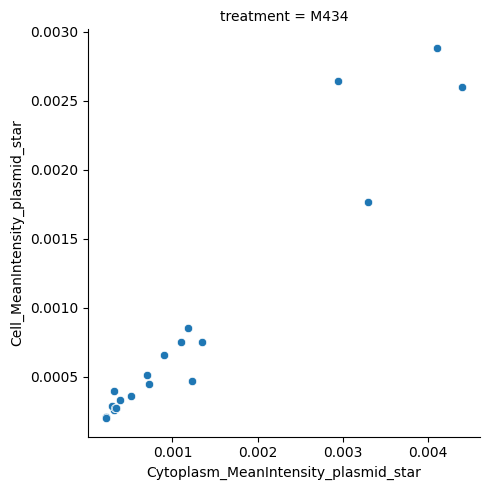

In [23]:
sns.relplot(data=data, row='treatment', x='Cytoplasm_MeanIntensity_plasmid_star', y='Cell_MeanIntensity_plasmid_star')

/tigress/tcomi/.conda/nuc-resnet/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


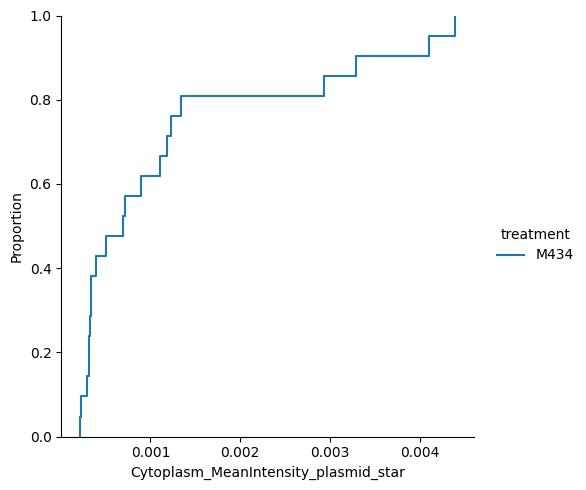

In [25]:
sns.displot(data=data, hue='treatment', x='Cytoplasm_MeanIntensity_plasmid_star', kind='ecdf')